In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# !pip install deskew

In [5]:
import pandas as pd

from iqradre.detect.pred import BoxesPredictor

from iqradre.recog.prod import TextPredictor
from iqradre.recog.prod import utils as text_utils

import transformers
from transformers import BertTokenizer
from iqradre.extract.prod.prod import Extractor

import matplotlib.pyplot as plt
from iqradre.detect.ops import boxes as boxes_ops
from iqradre.detect.ops import box_ops

In [6]:
transformers.__version__

'4.1.1'

In [7]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate

from deskew import determine_skew
import cv2 as cv

In [8]:
impath = 'images/test1.png'
img = cv.imread(impath)
shape = img.shape[:2]
shape.index(max(shape)), shape

(1, (750, 1000))

In [9]:
craft_weight = f'../weights/detect/craft_ktp_ohem.pth.tar'
crnn_path = '../weights/recog/ocrnet_pretrained_ktp.pth'
layoutlm_path = '../weights/extract/layoutlm_v2.pth'

In [10]:
predictor = BoxesPredictor(weight_path=craft_weight, device='cpu')
text_pred = TextPredictor(weight_path=crnn_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
extract = Extractor(tokenizer=tokenizer, weight=layoutlm_path)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [36]:
%%time
impath = 'images/ktp_aan/R_ktp6.jpg'
# impath = transform.do_autocrop_deskew(impath)
result = predictor.predict_word_boxes(impath, text_threshold=0.3, low_text=0.2)
polys, boxes, images_patch, img, score_text, score_link, ret_score_text = result

CPU times: user 478 ms, sys: 30.1 ms, total: 508 ms
Wall time: 270 ms


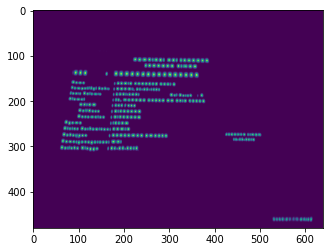

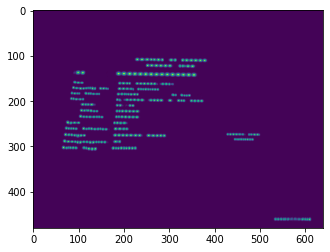

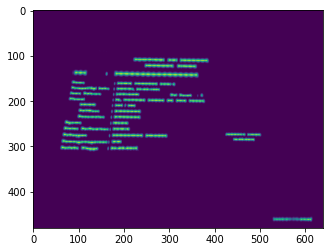

In [37]:
plt.imshow(score_text);plt.show()
plt.imshow(score_link);plt.show()
plt.imshow(score_text+score_link);plt.show()

1.0055865921787728


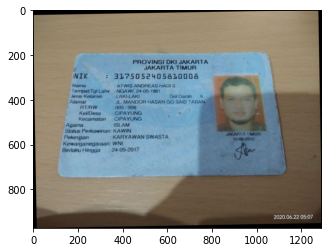

In [38]:
# image = io.imread('input.png')
# grayscale = rgb2gray(image)
angle = determine_skew(score_text+score_link)
rotated = rotate(img, angle, resize=True)
# io.imsave('output.png', rotated.astype(np.uint8))

plt.imshow(rotated)
img=rotated
print(angle)

In [39]:
boxes_list = box_ops.batch_box_coordinate_to_xyminmax(boxes, to_int=True).tolist()   
boxes_list[0]

[438.0, 203.0, 585.0, 234.0]

In [40]:
# import numpy as np
# boxes_proc = np.array(boxes_list)
# xmin, ymin = np.min(boxes_proc[:, 0]), np.min(boxes_proc[:, 1])
# xmax, ymax = np.max(boxes_proc[:, 2]), np.max(boxes_proc[:, 3])

# xmin, ymin, xmax, ymax

In [41]:
# !pip install deskew

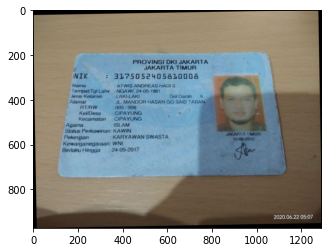

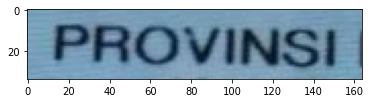

[438.0, 203.0, 585.0, 234.0]


In [42]:
idx = 0
plt.imshow(img);plt.show()
plt.imshow(images_patch[idx]);plt.show()
print(boxes_list[idx])

In [43]:
%%time
text_list = text_pred.predict(images_patch)

CPU times: user 9.93 s, sys: 240 ms, total: 10.2 s
Wall time: 1.36 s


PROVINSI


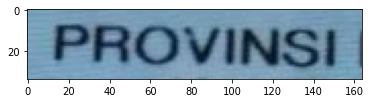

DKI


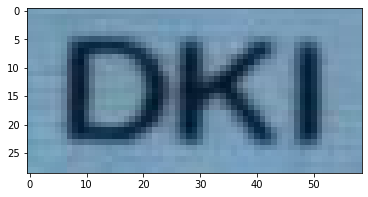

JAKARTA


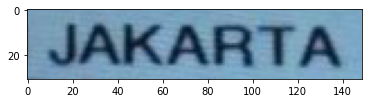

JAKARTA


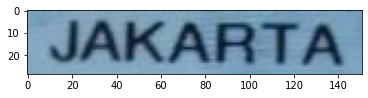

TIMUR


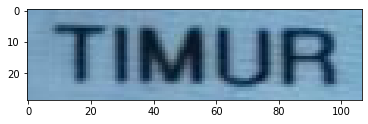

NIK


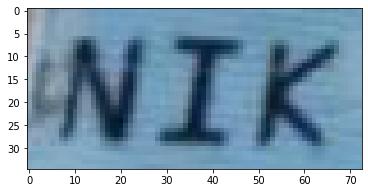

3175052405810008


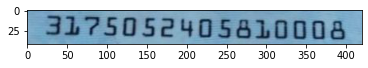

I.


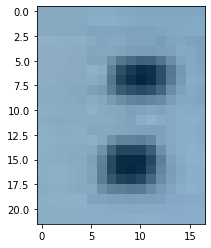

Nama


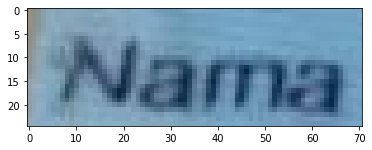

ATWIS


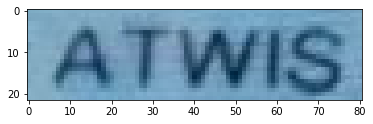

ANDREAS


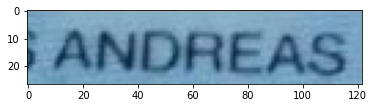

IW


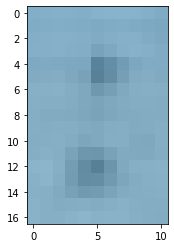

HADI


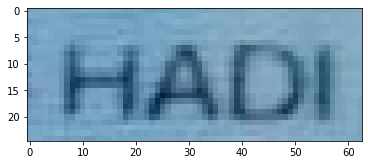

S--


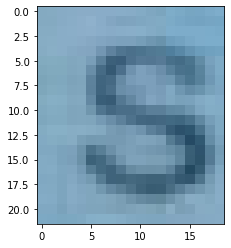

Tempat/Tgl


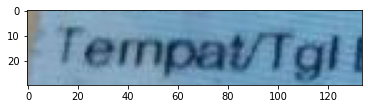

Lahir


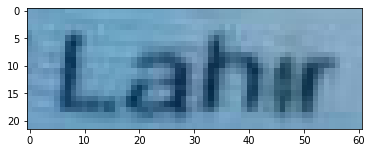

NGAWI,


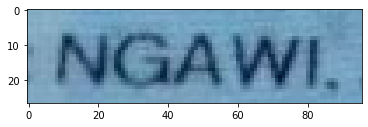

JM


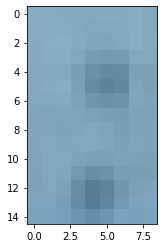

.24-05-1981


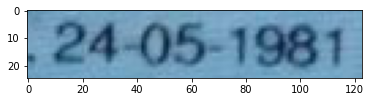

Jenis


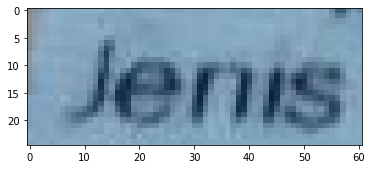

Kelamin


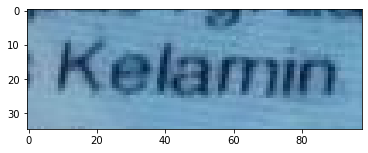

LAKI-LAKI


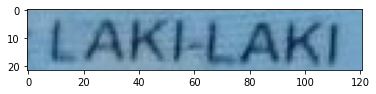

ali


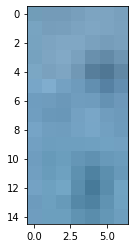

Gola


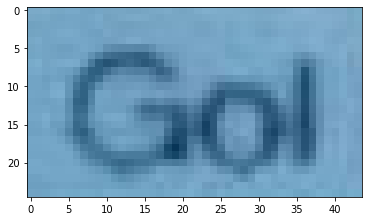

Darah


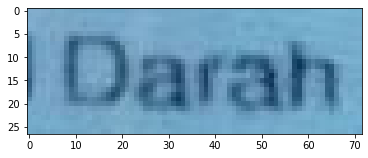

AW


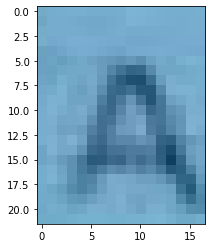

Alamat


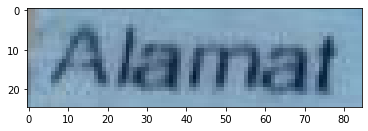

JLP-T


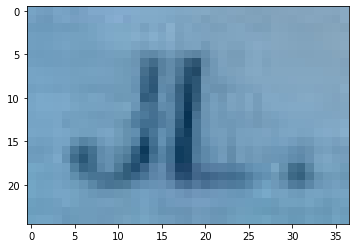

MANDOR


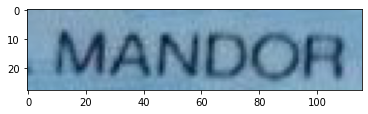

LI-


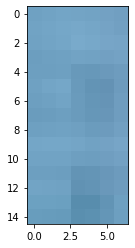

HASAN


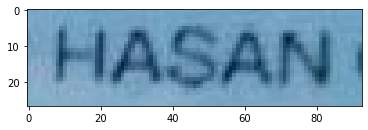

GGH


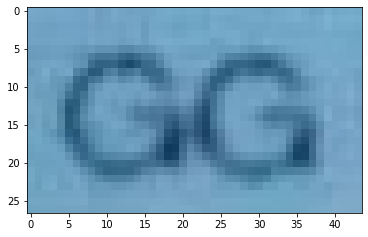

SAID


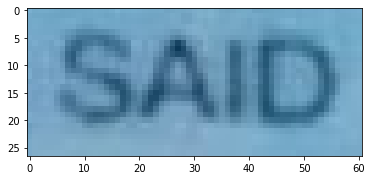

TABAN


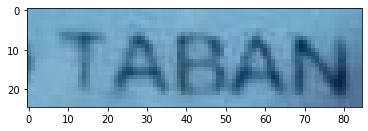

RT/RW


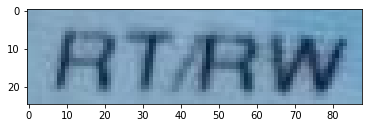

005


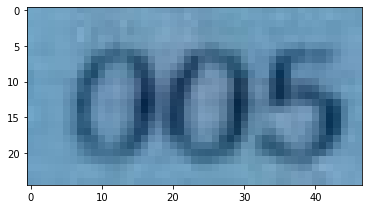

/e


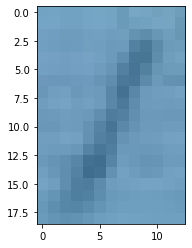

IW


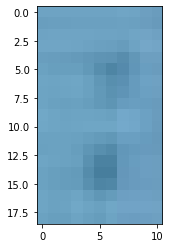

006


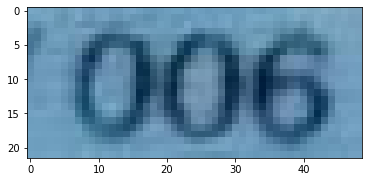

Kel/Desa


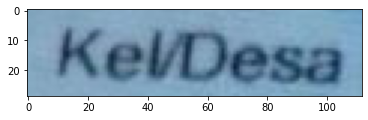

CIPAYUNG


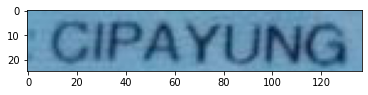

RET


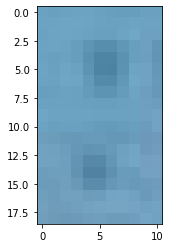

Kecamatan


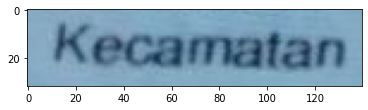

CIPAYUNG


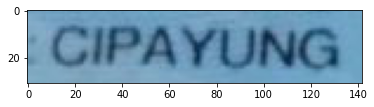

-


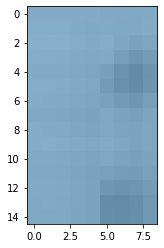

Agama


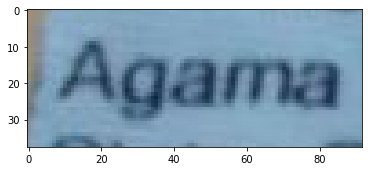

ISLAM


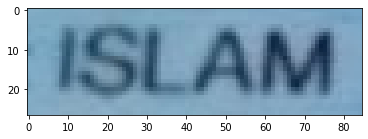

S,


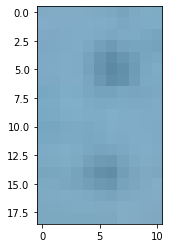

Status


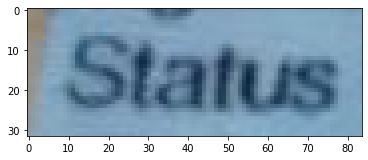

Perkawinan


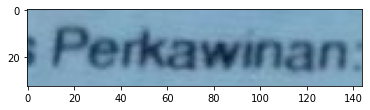

KAWIN


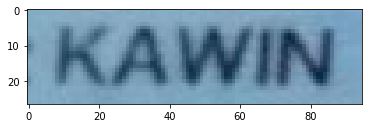

Lang


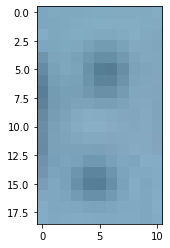

Pekerjaan


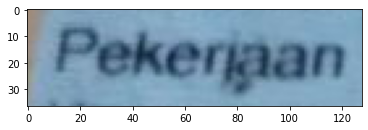

JAKARTA


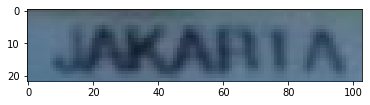

TIMUR


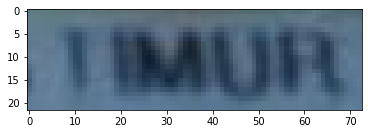

KARYAWAN


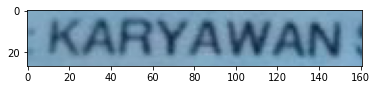

ISWASTA


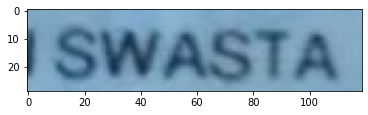

L.


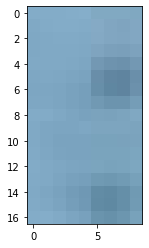

10-06-2012


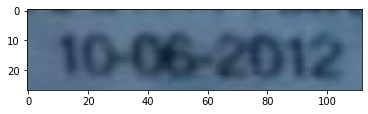

Kewarganegaraan


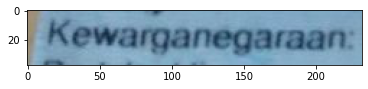

WNI


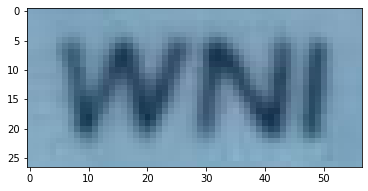

UK


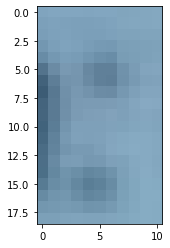

Berlaku


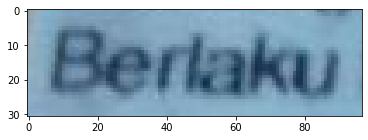

Hingga


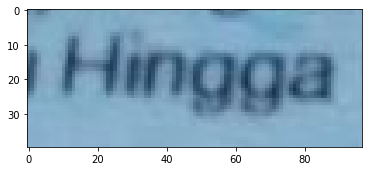

.4-05-2017


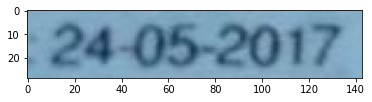

SE


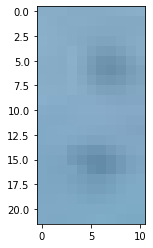

22200


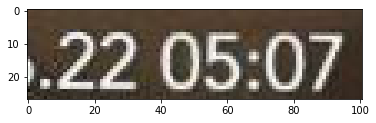

2020.06.


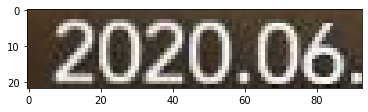

In [44]:
for text, img in zip(text_list, images_patch):
    print(text)    
    plt.imshow(img);plt.show()


In [53]:
data_annoset = text_utils.build_annoset(text_list, boxes)
data_annoset = sorted(data_annoset, key = lambda i: (i['bbox'][1], i['bbox'][0]))

In [54]:
data_annoset

[{'text': 'PROVINSI', 'bbox': [438.0, 203.0, 585.0, 234.0]},
 {'text': 'DKI', 'bbox': [588.0, 208.0, 642.0, 234.0]},
 {'text': 'JAKARTA', 'bbox': [644.0, 208.0, 780.0, 236.0]},
 {'text': 'JAKARTA', 'bbox': [488.0, 232.0, 626.0, 258.0]},
 {'text': 'TIMUR', 'bbox': [630.0, 234.0, 728.0, 260.0]},
 {'text': 'NIK', 'bbox': [176.0, 260.0, 242.0, 292.0]},
 {'text': '3175052405810008', 'bbox': [354.0, 263.0, 733.0, 302.0]},
 {'text': 'I.', 'bbox': [316.0, 270.0, 332.0, 290.0]},
 {'text': 'Nama', 'bbox': [166.0, 306.0, 230.0, 328.0]},
 {'text': 'ANDREAS', 'bbox': [442.0, 311.0, 551.0, 335.0]},
 {'text': 'ATWIS', 'bbox': [366.0, 312.0, 440.0, 332.0]},
 {'text': 'HADI', 'bbox': [554.0, 314.0, 612.0, 336.0]},
 {'text': 'IW', 'bbox': [356.0, 316.0, 366.0, 332.0]},
 {'text': 'S--', 'bbox': [612.0, 316.0, 630.0, 336.0]},
 {'text': 'Tempat/Tgl', 'bbox': [164.0, 329.0, 283.0, 356.0]},
 {'text': 'Lahir', 'bbox': [284.0, 334.0, 340.0, 354.0]},
 {'text': 'NGAWI,', 'bbox': [364.0, 334.0, 449.0, 358.0]},
 {

In [55]:
data, clean = extract.predict(data_annoset)

IndexError: The :obj:`bbox`coordinate values should be within 0-1000 range.

In [51]:
data

NameError: name 'data' is not defined

In [35]:
pd.set_option("max_rows", None)
pd.DataFrame(clean)

NameError: name 'clean' is not defined

In [ ]:
trans